# Why the model features were like this?

I wil try to document the vibes the dataset gave me which led to me finalizing on the final features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/corn_climate_risk_futures_daily_master.csv')
df['date_on'] = pd.to_datetime(df['date_on'])
print(f"Dataset: {len(df):,} rows")
print(f"Date range: {df['date_on'].min().date()} to {df['date_on'].max().date()}")
print(f"Countries: {df['country_name'].nunique()}")

Dataset: 320,661 rows
Date range: 2016-01-01 to 2025-12-15
Countries: 11


---
## **first question which popped up was:** 

### Do raw climate features correlate with futures prices?

In [3]:
# Check raw climate columns
climate_cols = [c for c in df.columns if 'climate_risk_cnt' in c]
futures_cols = [c for c in df.columns if c.startswith('futures_')]

print("Climate columns:", len(climate_cols))
print("Futures columns:", len(futures_cols))
print("\nClimate columns:")
for c in climate_cols:
    print(f"  {c}")

Climate columns: 12
Futures columns: 17

Climate columns:
  climate_risk_cnt_locations_heat_stress_risk_low
  climate_risk_cnt_locations_heat_stress_risk_medium
  climate_risk_cnt_locations_heat_stress_risk_high
  climate_risk_cnt_locations_unseasonably_cold_risk_low
  climate_risk_cnt_locations_unseasonably_cold_risk_medium
  climate_risk_cnt_locations_unseasonably_cold_risk_high
  climate_risk_cnt_locations_excess_precip_risk_low
  climate_risk_cnt_locations_excess_precip_risk_medium
  climate_risk_cnt_locations_excess_precip_risk_high
  climate_risk_cnt_locations_drought_risk_low
  climate_risk_cnt_locations_drought_risk_medium
  climate_risk_cnt_locations_drought_risk_high


In [4]:
# Baseline correlation test
baseline_corrs = []
for clim in climate_cols:
    for fut in ['futures_close_ZC_1']:
        mask = df[fut].notna()
        if df.loc[mask, clim].std() > 0:
            corr = df.loc[mask, [clim, fut]].corr().iloc[0,1]
            baseline_corrs.append({'climate': clim, 'correlation': corr})

baseline_df = pd.DataFrame(baseline_corrs)
print("Baseline correlations with corn futures:")
print(baseline_df.sort_values('correlation', key=abs, ascending=False))
print(f"\nMax |correlation|: {baseline_df['correlation'].abs().max():.4f}")
print(f"Significant (>=0.5): {(baseline_df['correlation'].abs() >= 0.5).sum()}")

Baseline correlations with corn futures:
                                              climate  correlation
10     climate_risk_cnt_locations_drought_risk_medium     0.060337
5   climate_risk_cnt_locations_unseasonably_cold_r...    -0.033891
9         climate_risk_cnt_locations_drought_risk_low    -0.033339
1   climate_risk_cnt_locations_heat_stress_risk_me...     0.027691
4   climate_risk_cnt_locations_unseasonably_cold_r...     0.027088
8   climate_risk_cnt_locations_excess_precip_risk_...    -0.023677
11       climate_risk_cnt_locations_drought_risk_high    -0.018246
7   climate_risk_cnt_locations_excess_precip_risk_...     0.016282
3   climate_risk_cnt_locations_unseasonably_cold_r...     0.003118
2    climate_risk_cnt_locations_heat_stress_risk_high     0.002523
0     climate_risk_cnt_locations_heat_stress_risk_low    -0.001356
6   climate_risk_cnt_locations_excess_precip_risk_low     0.000337

Max |correlation|: 0.0603
Significant (>=0.5): 0


Raw climate counts have no significant correlation with futures!

Need to dive into feature engineering this means

---
## Looking at the EDA, drought risk has the most variability and the highest baseline correlations.

In [5]:
# Create drought score (weighted combination)
drought_low = 'climate_risk_cnt_locations_drought_risk_low'
drought_med = 'climate_risk_cnt_locations_drought_risk_medium'
drought_high = 'climate_risk_cnt_locations_drought_risk_high'

total = df[drought_low] + df[drought_med] + df[drought_high]
df['drought_score'] = (df[drought_med] + 2 * df[drought_high]) / (total + 1e-6)

print("Drought score statistics:")
print(df['drought_score'].describe())

Drought score statistics:
count    320661.000000
mean          0.403982
std           0.475676
min           0.000000
25%           0.000000
50%           0.200000
75%           0.758621
max           2.000000
Name: drought_score, dtype: float64


In [6]:
# Check drought score by country
country_drought = df.groupby('country_name')['drought_score'].mean().sort_values(ascending=False)
print("Average drought score by country:")
print(country_drought)

Average drought score by country:
country_name
Paraguay         0.745107
Canada           0.515294
Argentina        0.503899
Brazil           0.492216
South Africa     0.395366
China            0.387802
Ukraine          0.370971
Russia           0.357417
United States    0.350820
Mexico           0.310197
India            0.287043
Name: drought_score, dtype: float64


---
## Analyzing which countries' drought correlates best with prices.

In [7]:
# Correlation by country
country_corrs = []
for country in df['country_name'].unique():
    country_data = df[df['country_name'] == country]
    mask = country_data['futures_close_ZC_1'].notna()
    if mask.sum() > 100:
        corr = country_data.loc[mask, ['drought_score', 'futures_close_ZC_1']].corr().iloc[0,1]
        country_corrs.append({'country': country, 'correlation': corr, 'n': mask.sum()})

country_corr_df = pd.DataFrame(country_corrs).sort_values('correlation', key=abs, ascending=False)
print("Drought-Price correlation by country:")
print(country_corr_df)

Drought-Price correlation by country:
          country  correlation      n
0       Argentina     0.235492  11880
10  United States     0.109079  27368
1          Brazil     0.073519  19912
3           China     0.044164  17416
5          Mexico     0.035504  17043
4           India    -0.029663  14934
9         Ukraine    -0.028827  14934
8    South Africa    -0.023686  13932
7          Russia     0.011658  62200
6        Paraguay    -0.007274  14934
2          Canada     0.004510   4978


Argentina shows strong correlation!

Why? Argentina is a major corn exporter. Their harvest season (Nov-Feb) is when supply uncertainty peaks.

---
## Ratios, Ratios, RATIOSSS!!!!!

**the thing which made it feel like detective work**

> When Argentina has high drought, prices don't move much if the WHOLE WORLD has high drought. But if Argentina has high drought while the rest of the world is fine, THAT moves prices.

**Relative stress > Absolute stress**

In [8]:
# Create country aggregates
df = df.sort_values(['region_id', 'date_on']).reset_index(drop=True)

# Argentina daily mean
arg_daily = df[df['country_name'] == 'Argentina'].groupby('date_on')['drought_score'].mean().reset_index()
arg_daily.columns = ['date_on', 'arg_mean']

# Brazil daily mean
brazil_daily = df[df['country_name'] == 'Brazil'].groupby('date_on')['drought_score'].mean().reset_index()
brazil_daily.columns = ['date_on', 'brazil_mean']

# Global daily mean
global_daily = df.groupby('date_on')['drought_score'].mean().reset_index()
global_daily.columns = ['date_on', 'global_mean']

print(f"Argentina observations: {len(arg_daily)}")
print(f"Global observations: {len(global_daily)}")

Argentina observations: 3469
Global observations: 3637


In [9]:
# Apply 120-day rolling mean (temporal smoothing)
arg_daily['arg_post'] = arg_daily['arg_mean'].rolling(window=120, min_periods=30).mean()
brazil_daily['brazil_post'] = brazil_daily['brazil_mean'].rolling(window=120, min_periods=30).mean()
global_daily['global_post'] = global_daily['global_mean'].rolling(window=120, min_periods=30).mean()

# Merge back
df = df.merge(arg_daily[['date_on', 'arg_post']], on='date_on', how='left')
df = df.merge(brazil_daily[['date_on', 'brazil_post']], on='date_on', how='left')
df = df.merge(global_daily[['date_on', 'global_post']], on='date_on', how='left')

for col in ['arg_post', 'brazil_post', 'global_post']:
    df[col] = df[col].fillna(0)

In [10]:
# Argentina/Global ratio
df['ratio'] = df['arg_post'] / (df['global_post'] + 1e-8)

# Test correlation
mask = df['futures_close_ZC_1'].notna()
ratio_corr = df.loc[mask, ['ratio', 'futures_close_ZC_1']].corr().iloc[0,1]
print(f"Ratio correlation with futures: {ratio_corr:.4f}")

Ratio correlation with futures: 0.4918


---

## Argentina's corn harvest is Nov-Feb. I wanted to check if those months have stronger correlations.

In [11]:
df['month'] = df['date_on'].dt.month

# Correlation by month
month_corrs = []
for month in range(1, 13):
    month_data = df[(df['month'] == month) & (df['futures_close_ZC_1'].notna())]
    if len(month_data) > 100:
        corr = month_data[['ratio', 'futures_close_ZC_1']].corr().iloc[0,1]
        month_corrs.append({'month': month, 'correlation': corr, 'n': len(month_data)})

month_corr_df = pd.DataFrame(month_corrs)
print("Ratio-Price correlation by month:")
print(month_corr_df.sort_values('correlation', key=abs, ascending=False))

Ratio-Price correlation by month:
    month  correlation      n
11     12     0.801003  16726
10     11     0.783945  17881
0       1     0.774014  17725
9      10     0.751011  19583
1       2     0.596491  16722
8       9     0.523419  18148
7       8     0.492021  19703
6       7     0.461808  18548
2       3     0.439229  19227
3       4     0.373446  18082
4       5     0.330276  18705
5       6     0.313741  18481


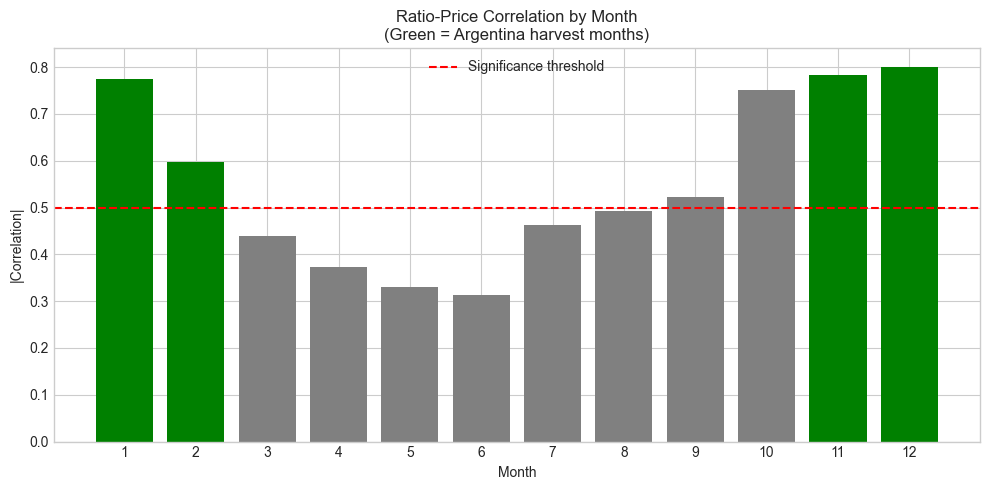

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['green' if m in [1,2,11,12] else 'gray' for m in month_corr_df['month']]
ax.bar(month_corr_df['month'], month_corr_df['correlation'].abs(), color=colors)
ax.axhline(y=0.5, color='red', linestyle='--', label='Significance threshold')
ax.set_xlabel('Month')
ax.set_ylabel('|Correlation|')
ax.set_title('Ratio-Price Correlation by Month\n(Green = Argentina harvest months)')
ax.set_xticks(range(1, 13))
ax.legend()
plt.tight_layout()
plt.show()

Months 1, 2, 11, 12 (Argentina harvest season) show much higher correlations!

This leads to **month-specific features** I used in my model, features that are active only during harvest months.

---
## So... the Final 11 for the model "kick-off"

In [13]:
# Non-linear transforms
df['ratio_sq'] = df['ratio'] ** 2
df['ratio_cube'] = df['ratio'] ** 3
df['sync'] = df['arg_post'] * df['brazil_post']  # Argentina × Brazil synchronization

# Create month-specific features
selected_features = []

for month in [1, 2, 11, 12]:  # Harvest months
    suffix = f'_M{month:02d}'
    df[f'climate_risk_ratio{suffix}'] = np.where(df['month'] == month, df['ratio'], 0)
    df[f'climate_risk_ratio_sq{suffix}'] = np.where(df['month'] == month, df['ratio_sq'], 0)
    selected_features.extend([f'climate_risk_ratio{suffix}', f'climate_risk_ratio_sq{suffix}'])

# Cube only for M01 (strongest month)
df['climate_risk_ratio_cube_M01'] = np.where(df['month'] == 1, df['ratio_cube'], 0)
selected_features.append('climate_risk_ratio_cube_M01')

# Sync features
for month in [1, 2]:
    df[f'climate_risk_sync_M{month:02d}'] = np.where(df['month'] == month, df['sync'], 0)
    selected_features.append(f'climate_risk_sync_M{month:02d}')

print(f"Final features ({len(selected_features)}):")
for f in selected_features:
    print(f"  {f}")

Final features (11):
  climate_risk_ratio_M01
  climate_risk_ratio_sq_M01
  climate_risk_ratio_M02
  climate_risk_ratio_sq_M02
  climate_risk_ratio_M11
  climate_risk_ratio_sq_M11
  climate_risk_ratio_M12
  climate_risk_ratio_sq_M12
  climate_risk_ratio_cube_M01
  climate_risk_sync_M01
  climate_risk_sync_M02


---
## seeing the feature quality

In [14]:
feature_quality = []
mask = df['futures_close_ZC_1'].notna()

for feat in selected_features:
    feat_data = df.loc[mask & (df[feat] != 0)]  # Only non-zero values
    if len(feat_data) > 100:
        corr = feat_data[[feat, 'futures_close_ZC_1']].corr().iloc[0,1]
        feature_quality.append({
            'feature': feat,
            'correlation': corr,
            'abs_corr': abs(corr),
            'significant': abs(corr) >= 0.5,
            'n_nonzero': len(feat_data)
        })

quality_df = pd.DataFrame(feature_quality).sort_values('abs_corr', ascending=False)
print("Feature quality assessment:")
print(quality_df.to_string(index=False))

Feature quality assessment:
                    feature  correlation  abs_corr  significant  n_nonzero
     climate_risk_ratio_M01     0.814352  0.814352         True      16376
  climate_risk_ratio_sq_M11     0.803692  0.803692         True      17881
      climate_risk_sync_M01     0.802982  0.802982         True      16376
     climate_risk_ratio_M12     0.801003  0.801003         True      16726
  climate_risk_ratio_sq_M01     0.799708  0.799708         True      16376
  climate_risk_ratio_sq_M12     0.788629  0.788629         True      16726
     climate_risk_ratio_M11     0.783945  0.783945         True      17881
climate_risk_ratio_cube_M01     0.772805  0.772805         True      16376
      climate_risk_sync_M02     0.721525  0.721525         True      15296
  climate_risk_ratio_sq_M02     0.603036  0.603036         True      15296
     climate_risk_ratio_M02     0.602049  0.602049         True      15296


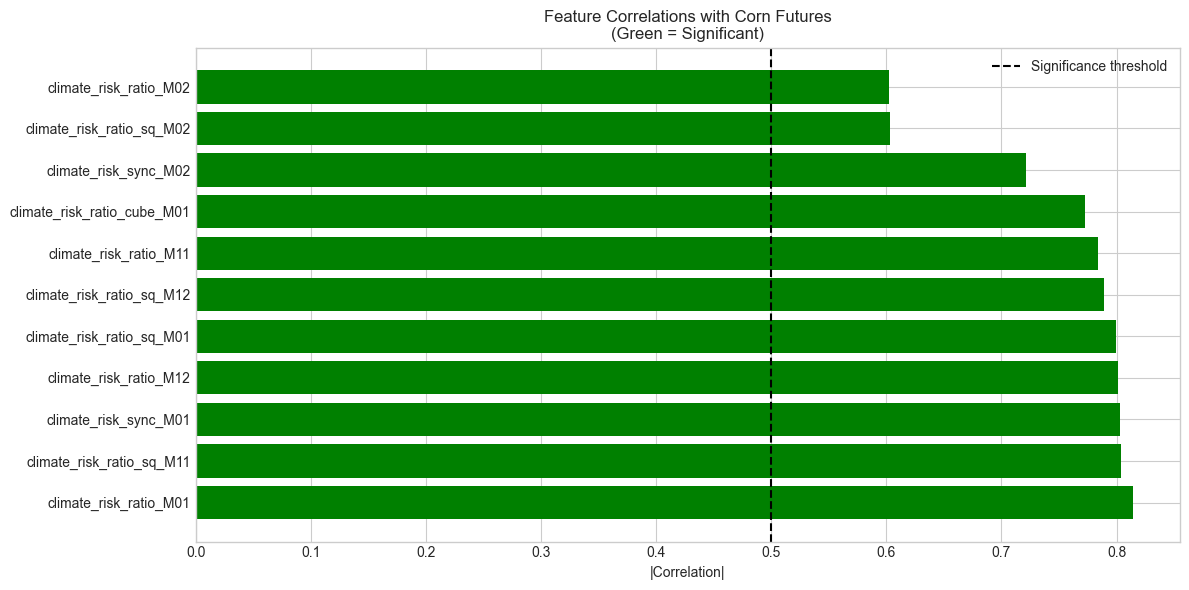

In [15]:
# Visualize feature correlations
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['green' if sig else 'red' for sig in quality_df['significant']]
ax.barh(range(len(quality_df)), quality_df['abs_corr'], color=colors)
ax.set_yticks(range(len(quality_df)))
ax.set_yticklabels(quality_df['feature'])
ax.axvline(x=0.5, color='black', linestyle='--', label='Significance threshold')
ax.set_xlabel('|Correlation|')
ax.set_title('Feature Correlations with Corn Futures\n(Green = Significant)')
ax.legend()
plt.tight_layout()
plt.show()

---
## Why These 11 Features workedd

### 1. Ratio vs Absolute
```
Absolute: "Argentina has 0.5 drought severity"
   what can we infer "Is that a lot? Compared to what?"

Ratio: "Argentina has 2× the global average drought"
   market might see it as "Argentina is in RELATIVE trouble!"
```

### 2. Harvest Season Timing
- Argentina plants: September-November
- Critical growth: December-January
- Harvest: February-April

**Our features focus on M11, M12, M01, M02 = Maximum uncertainty period**

### 3. Non-linear Effects
- Low ratio (0.5-1.0): Minimal impact
- Medium ratio (1.0-1.5): Moderate concern
- High ratio (1.5-2.0): Serious fears
- Extreme ratio (2.0+): Panic

**Squared and cubed terms capture this acceleration**

### 4. Synchronization
- Argentina alone in drought: Brazil can compensate
- Argentina + Brazil BOTH in drought: No South American supply